![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [26]:
import warnings
warnings.filterwarnings('ignore')

In [27]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn import metrics
from sklearn.tree import plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Vatasetisualización d
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


### **ANÁLISIS DESCRIPTIVO**

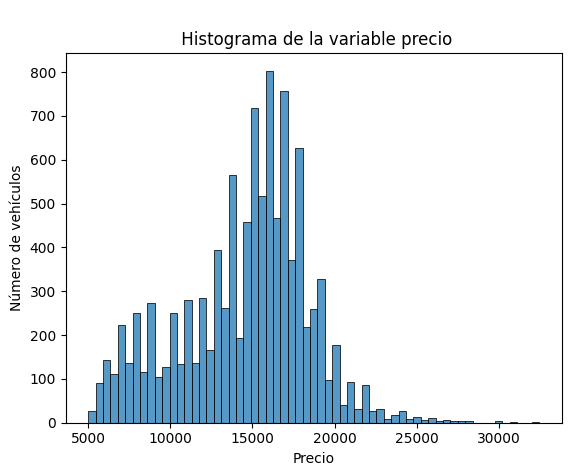

Estadisticas descriptivas de variable Price


,Price
count,10495.000000
mean,14538.403716
std,3922.420961
min,5002.000000
25%,11999.000000
50%,15000.000000
75%,16999.000000
max,32444.000000


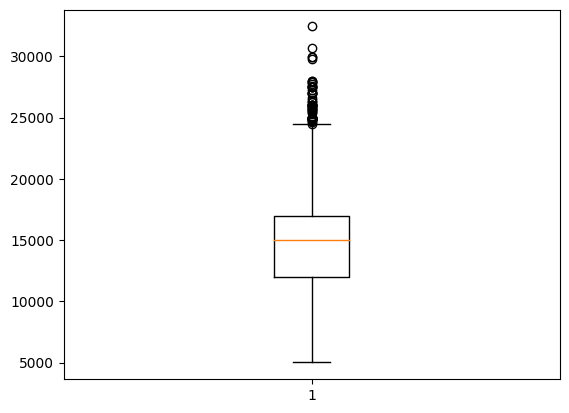

In [28]:
#Variable a predecir

p=sns.histplot(data['Price'], bins="auto" )
plt.title("\n Histograma de la variable precio")
plt.xlabel("Precio")
plt.ylabel("Número de vehículos")
plt.show()

print("Estadisticas descriptivas de variable Price")
display(pd.DataFrame(data.Price.describe()))

plt.boxplot(data['Price'])
plt.show()

Respecto a la variable a predecir Price, se puede decir que posee una distribución normal pues los datos se agrupan hacia la media, con una media de 14.538, en los datos esta variable presenta un mínimo de 5002 y un máximo de 32.444. Posee una desviación estandar de 3922 y el 75% de los datos poseen un valor igual o inferior a 16.999 en la variable Price.

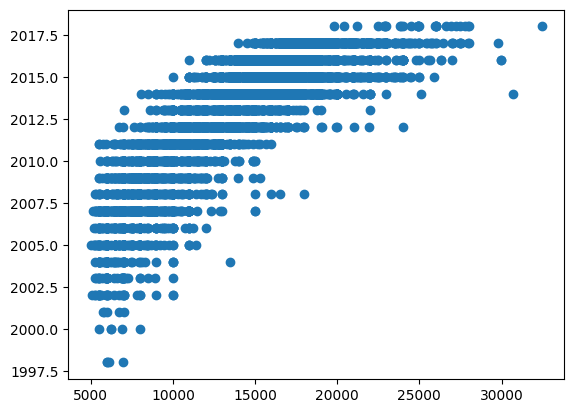

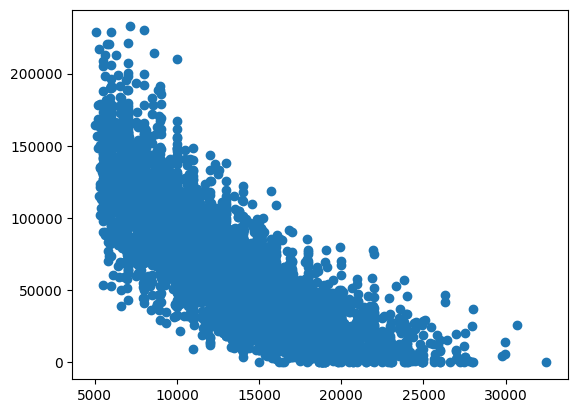

In [29]:
#Variables predictoras
fig, ax = plt.subplots()
ax.scatter( data['Price'],data['Year'])
plt.show()

#Variables predictoras
fig, ax = plt.subplots()
ax.scatter(data['Price'],data['Mileage'] )
plt.show()

Respecto al análisis de la variable Price con sus predictoras, se puede observar que hay dos relaciones que llaman la atención, con las variables Year y con la variable Mileage. En el scatter realizado en la parte superior se puede observar la correlación positiva que presenta esta variable con la variable Year en los datos, y además se puede observar la correlación negativa que presenta con la variable Mileage.

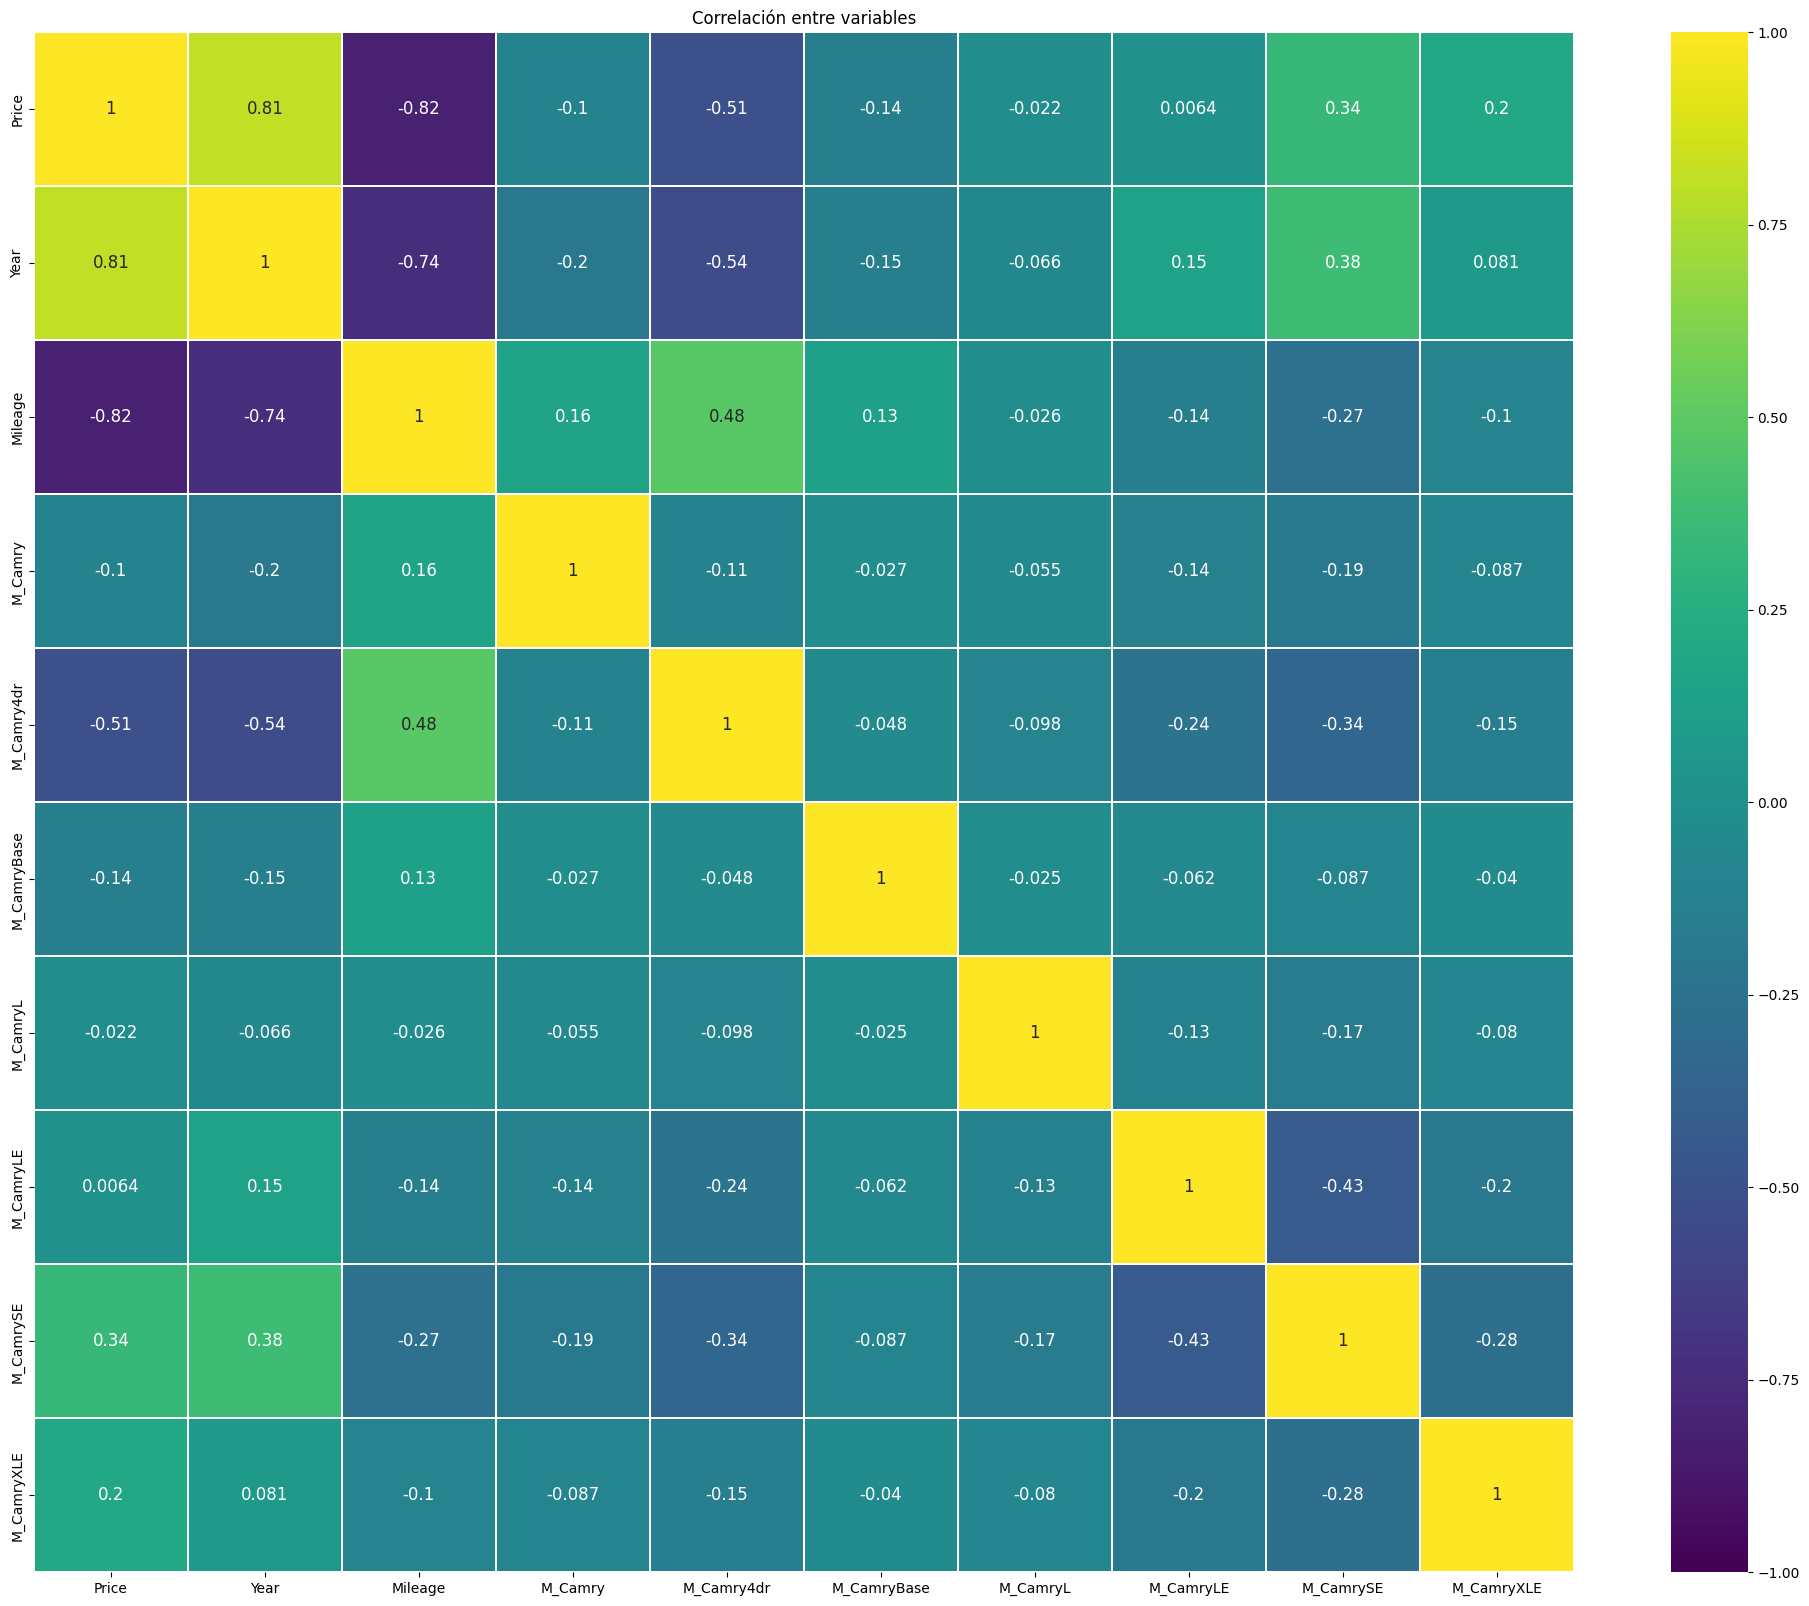

In [30]:
# Gráfico de correlaciones
corr = data.corr(method='spearman')
plt.figure(figsize=(25,20))
plt.title("Correlación entre variables")
sns.heatmap(corr[(corr >= 0.0) | (corr <= -0)],
           cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
           annot=True, annot_kws={"size": 12}, square=True);

En el gráfico de correlaciones entre las variables de los datos se puede observar que hay una correlación positiva entre la variable Precio y la variable Year, de aquí se puede inferir que la inflación anual puede ser la variable omitida que está causando esta correlación puesto que mientras pasan los años se van aumentando los niveles de precios en general en la economía. Además, se puede observar que hay una correlación negativa entre el precio con el Mileage que es la cantidad de millas que el carro ha recorrido, lo cual hace sentido desde que entre más usado esté un carro puede considerarse que está más depreciado respecto a su valor.

In [31]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [32]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [33]:
# Celda 1
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, var_red=None, value=None):
        
        # Nodo de decisión
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.var_red = var_red
        
        # Nodo hoja
        self.value = value

class DecisionTreeRegressor():
    def __init__(self, min_samples_split=2, max_depth=2):

        self.root = None
        
        # Para condiciones
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree '''
       
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        best_split = {}

        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # Encuentra el mejor split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # Revisar si gain es positivo
            if best_split["var_red"]>0:
                # Izquierda
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # Derecha
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # Retorno a nodo de decisión
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["var_red"])
        # Hoja nodo
        leaf_value = self.calculate_leaf_value(Y)
        # Retorna a hoja nodo
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
   
        # Diciconario para almacenar el mejor split
        best_split = {}
        max_var_red = -float("inf")
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            for threshold in possible_thresholds:
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # Información gain
                    curr_var_red = self.variance_reduction(y, left_y, right_y)
                    # Actualiza el mejor split
                    if curr_var_red>max_var_red:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["var_red"] = curr_var_red
                        max_var_red = curr_var_red
                        
        # Retorna el mejor split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
           
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def variance_reduction(self, parent, l_child, r_child):
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        reduction = np.var(parent) - (weight_l * np.var(l_child) + weight_r * np.var(r_child))
        return reduction
    
    def calculate_leaf_value(self, Y):
       
        val = np.mean(Y)
        return val
                
    def print_tree(self, tree=None, indent=" "):
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.var_red)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
        
    def make_prediction(self, x, tree):
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)
    
    def predict(self, X):
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions

In [34]:
regressor = DecisionTreeRegressor(min_samples_split=3, max_depth=3)
regressor.fit(X_train.values,y_train.values.reshape(-1,1))
regressor.print_tree()

X_0 <= 2012 ? 8790046.173046965
 left:X_0 <= 2011 ? 2959465.8517095316
  left:X_1 <= 99121 ? 1170116.721087044
    left:X_0 <= 2007 ? 893698.6400833833
        left:8403.308823529413
        right:10479.29531568228
    right:X_0 <= 2009 ? 552919.3704753756
        left:7233.494485294118
        right:8878.844036697248
  right:X_1 <= 82133 ? 1363726.4906349215
    left:X_1 <= 47312 ? 504080.0386649659
        left:14652.202127659575
        right:13077.713080168776
    right:X_1 <= 112714 ? 363719.12316599186
        left:11426.666666666666
        right:10010.15909090909
 right:X_0 <= 2016 ? 1620597.6461158656
  left:X_1 <= 49121 ? 910016.9812996429
    left:X_1 <= 25773 ? 381099.80697076535
        left:17245.66734279919
        right:15898.380538662033
    right:X_1 <= 70061 ? 776981.4839276252
        left:14624.099041533545
        right:12750.181229773463
  right:X_8 <= 0 ? 1093632.8568244968
    left:X_0 <= 2017 ? 800646.9773042481
        left:18672.143669985777
        right:25

In [35]:
y_pred = regressor.predict(X_test.values) 
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print("RMSE:", rmse)
print("MAE:", mae)


RMSE: 1786.7701175453772
MAE: 1338.7678256052181


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [36]:
# Celda 2
from random import randrange
def subsample(x,y, ratio):
	sample = list()
	ysample=list()
	n_sample = round(len(x) * ratio)
	while len(sample) < n_sample:
		index = randrange(len(x))
		sample.append(x[index])
		ysample.append(y[index])
	return sample,ysample

# Bootstrap
def bagging(X_train,y_train,X_test,sample_size=0.5):
	trees = list()
	for i in range(0,10):
		sample,ysample = subsample(X_train.values,y_train.values.reshape(-1,1), sample_size)
		reg = DecisionTreeRegressor(min_samples_split=3, max_depth=3)
		reg.fit(sample,ysample)
		trees.append(reg)
	predictions = [tree.predict(X_test.values) for tree in trees]
	predictions =pd.DataFrame(predictions).mean().values
	return(predictions)

preds=bagging(X_train,y_train,X_test, sample_size=0.5)


In [37]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)
print("RMSE:", rmse)
print("MAE:", mae)

RMSE: 1681.409274104567
MAE: 1244.4111811524126


El modelo bagging manual obtiene un error mucho mayor tanto en términos de RMSE como de MAE. Esto sugiere que la técnica de bagging no es efectiva para mejorar el rendimiento del modelo. Por lo tanto, el modelo bagging manual no es una buena técnica para mejorar el rendimiento del modelo y reducir la varianza en los datos de prueba.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [38]:
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error
from math import log

In [39]:
# Celda 3
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

n_features=2
base_model = DecisionTreeRegressor(random_state=42,max_depth=5)
bagging_model = BaggingRegressor(base_estimator=base_model,n_estimators=10,max_features=np.log(n_features), random_state=42)
bagging_model.fit(X_train, y_train)
y_pred=bagging_model.predict(X_test)
rmserbagging =  np.sqrt(mean_squared_error(y_pred, y_test))
print('RMSE:', np.sqrt(mean_squared_error(y_pred, y_test)))
maerbagging = mean_absolute_error(y_pred, y_test)
print('MAE:', mean_absolute_error(y_pred, y_test))

RMSE: 1622.3450691556634
MAE: 1209.2665406544402


El modelo Bagging con 10 árboles de clasificación y max_features igual a log(n_features) muestra un desempeño significativamente mejor que el modelo Bagging manual creado anteriormente. Tanto el RMSE como el MAE son  más bajos, lo que indica que el modelo está prediciendo mejor los precios de los automóviles.

En comparación con el árbol de decisión simple, el modelo Bagging muestra una mejora significativa en la precisión de la predicción. Esto sugiere que el modelo Bagging es una mejor opción para este problema y que el ajuste de hiperparámetros es esencial para mejorar el desempeño del modelo.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [57]:
# Celda 4
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Definición de modelo Random Forest para un problema de regresión
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)

#Impresión de desempeño del modelo
rmser=  np.sqrt(mean_squared_error(y_pred, y_test))
print('RMSE:', rmser)
maer = mean_absolute_error(y_pred, y_test)
print('MAE:', maer)


RMSE: 1762.2342949305003
MAE: 1311.228249038875


Los resultados del modelo de Random Forest no son mejores que los del modelo Bagging con los mismos parámetros. Esto indica que el modelo de Random Forest no es una buena opción para este problema y que no puede proporcionar una mayor precisión de predicción en comparación con los modelos probados anteriormente.

El modelo Random Forest no pudo proporcionar una mayor precisión de predicción y no es una buena opción cuando se requiere una mayor precisión y generalización del modelo.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [55]:
from sklearn.model_selection import GridSearchCV

# Definición de los valores de los parámetros a explorar
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'max_features': [int(np.log(X_train.shape[1])), 'sqrt', 'log2'],
    'n_estimators': [10, 50, 100, 200]
}

# Creación del modelo Random Forest
rf = RandomForestClassifier(random_state=42)
# Búsqueda de los mejores parámetros
rf_cv = GridSearchCV(rf, param_grid, cv=5)

In [56]:

rmsefc = np.sqrt(mean_squared_error(y_test, y_pred))
maefc = mean_absolute_error(y_test, y_pred)

print('RMSE:', rmsefc)
print('MAE:', maefc)

RMSE: 1760.2374696019947
MAE: 1310.8053317328438


Los mejores parámetros encontrados son max_depth=15, max_features=3 y n_estimators=200. Estos valores indican que un modelo con una profundidad máxima de 15, utilizando 3 características al azar para cada árbol y 200 árboles en el modelo, es el mejor para este problema.

El resultado del modelo es ligeramente mejor que los modelos anteriores, al ver el RMSE y el MAE. La calibración de los parámetros permitió mejorar la precisión del modelo.

Cada parámetro afecta el desempeño del modelo de la siguiente manera:

1. max_depth: controla la profundidad máxima del árbol de decisión. Un valor más alto permite que el modelo capture relaciones más complejas en los datos de entrenamiento, pero también puede conducir a sobreajuste. En este caso, un valor de 15 para max_depth es óptimo para el modelo.

2. max_features: controla la cantidad de características a considerar en cada división del árbol. Un valor más alto aumenta la complejidad del modelo, pero también puede aumentar la varianza. Los valores posibles son int(np.log(X_train.shape[1])), 'sqrt' y 'log2', que indican cuántas características se seleccionan al azar para cada árbol. En este caso, un valor de 3 para max_features es óptimo.

3. n_estimators: controla el número de árboles en el modelo. Un valor más alto aumenta la precisión del modelo, pero también aumenta el tiempo de entrenamiento. En este caso, un valor de 200 para n_estimators

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [43]:
# Celda 6
from xgboost import XGBRegressor

# Definición de modelo XGBoost para un problema de regresión
clf = XGBRegressor()
clf

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

rmseXB =  np.sqrt(mean_squared_error(y_pred, y_test))
print('RMSE:', np.sqrt(mean_squared_error(y_pred, y_test)))
maeXB = mean_absolute_error(y_pred, y_test)
print('MAE:', mean_absolute_error(y_pred, y_test))


RMSE: 1621.4197004256812
MAE: 1186.634392366123


El modelo XGBoost de regresión con la librería sklearn tiene un RMSE y un MAE que indican que el modelo tiene un desempeño mejor en la predicción del precio de los automóviles con respecto al random forest. Estos resultados se pueden mejorarse mediante la optimización de los hiperparámetros y la selección de características adecuadas.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [44]:
# Celda 7
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Definir el modelo base
model = XGBRegressor()

# Definir los parámetros a calibrar
params = {
    'learning_rate': [0.01, 0.1, 0.5],
    'gamma': [0, 0.1, 1],
    'colsample_bytree': [0.5, 0.8, 1]
}

In [45]:
# Realizar la búsqueda de parámetros óptimos
grid = GridSearchCV(model, params, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

# Imprimir los mejores parámetros y el mejor score obtenido
print("Best Parameters: ", grid.best_params_)
print("Best Score: ", -grid.best_score_)

Best Parameters:  {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.1}
Best Score:  2284814.1558396956


In [46]:
import xgboost as xgb

# Definir modelo con los parámetros óptimos
xgb_model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.1, gamma=0, colsample_bytree=0.5)

# Entrenamiento del modelo
xgb_model.fit(X_train, y_train)

# Predicción del modelo en datos de test
y_pred = xgb_model.predict(X_test)

# Cálculo del RMSE y MAE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("xgboost RMSE:", rmse)
print("xgboost MAE:", mae)

xgboost RMSE: 1614.9339355118796
xgboost MAE: 1182.2714202387504


El parámetro learning_rate controla la tasa de aprendizaje del modelo. Un learning_rate alto hace que el modelo aprenda más rápido, pero puede llevar a sobreajuste. Por otro lado, un learning_rate bajo hace que el modelo aprenda más lentamente, pero puede llevar a una mejor generalización. 

El parámetro gamma controla la cantidad mínima de reducción de pérdida necesaria para que se produzca una división adicional en un nodo hoja del árbol. Un valor alto de gamma hace que el modelo sea más conservador en la creación de nuevas divisiones, lo que puede evitar el sobreajuste. 

El parámetro colsample_bytree controla la fracción de columnas que se muestrean al construir cada árbol. Un valor alto de colsample_bytree hace que el modelo tenga más variedad en los árboles, lo que puede reducir el sobreajuste. 

En general, se espera que una calibración adecuada de los parámetros pueda mejorar el desempeño del modelo.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [58]:
# Celda 8
print('Random forest con librería RMSE:', rmser)
print('Random forest Calibrado RMSE:', rmsefc)
print('Xgboost RMSE:', rmseXB)
print("Xgboost Calibrado RMSE:", rmse)
print(" ")
print('Random forest con librería MAE :', maer)
print('Random forest Calibrado MAE:', maefc)
print('Xgboost MAE:', maeXB)
print("Xgboost Calibrado MAE:", mae)

Random forest con librería RMSE: 1762.2342949305003
Random forest Calibrado RMSE: 1760.2374696019947
Xgboost RMSE: 1621.4197004256812
Xgboost Calibrado RMSE: 1614.9339355118796
 
Random forest con librería MAE : 1311.228249038875
Random forest Calibrado MAE: 1310.8053317328438
Xgboost MAE: 1186.634392366123
Xgboost Calibrado MAE: 1182.2714202387504


El mejor modelo en términos de desempeño es el modelo XGBoost de regresión calibrado, ya que tiene un RMSE de 1614.93 y un MAE de 1182.271, los cuales son más bajos que el modelo Random Forest de regresión con librería y calibrado, y más bajos que el XG Boost con librería. Además, XGBoost es conocido por su capacidad para manejar grandes cantidades de datos y por ser más rápido y escalable que Random Forest. Otra de las ventajas de XGBoost es que es menos propenso a sobreajuste y además puede manejar variables categóricas y variables de texto.

Por otro lado, una desventaja del modelo Random Forest es que puede ser propenso al sobreajuste (overfitting) si no se ajustan adecuadamente los parámetros, ya que cada árbol de decisión en el bosque se entrena en una muestra aleatoria del conjunto de datos. Además, en general, los modelos basados en árboles de decisión como Random Forest pueden ser menos interpretables que otros modelos, lo que puede dificultar la comprensión de los resultados por parte de los usuarios.